
===== PART 1: DATA LOADING AND PREPARATION =====
Dataset shape: (969, 36)

Summary statistics for key columns:
              Age      Tenure     ActBal_CA      ActBal_SA      ActBal_MF  \
count  969.000000  969.000000    969.000000     265.000000     184.000000   
mean    42.983488  100.393189   2493.026329   14427.773550   21250.471671   
std     18.578951   65.437097   6268.027982   32615.370810   77683.063992   
min      0.000000    0.000000      0.000000       0.000000       0.000000   
25%     29.000000   42.000000     73.135000     725.631429       0.000000   
50%     41.000000   95.000000    536.951429    4352.067857    1953.776429   
75%     57.000000  151.000000   2262.178929   13326.190357   11241.016339   
max     90.000000  271.000000  74934.956071  389883.830714  761235.504286   

          Sale_MF     Sale_CC     Sale_CL  
count  969.000000  969.000000  969.000000  
mean     0.199174    0.249742    0.299278  
std      0.399586    0.433087    0.458178  
min      0.000000 

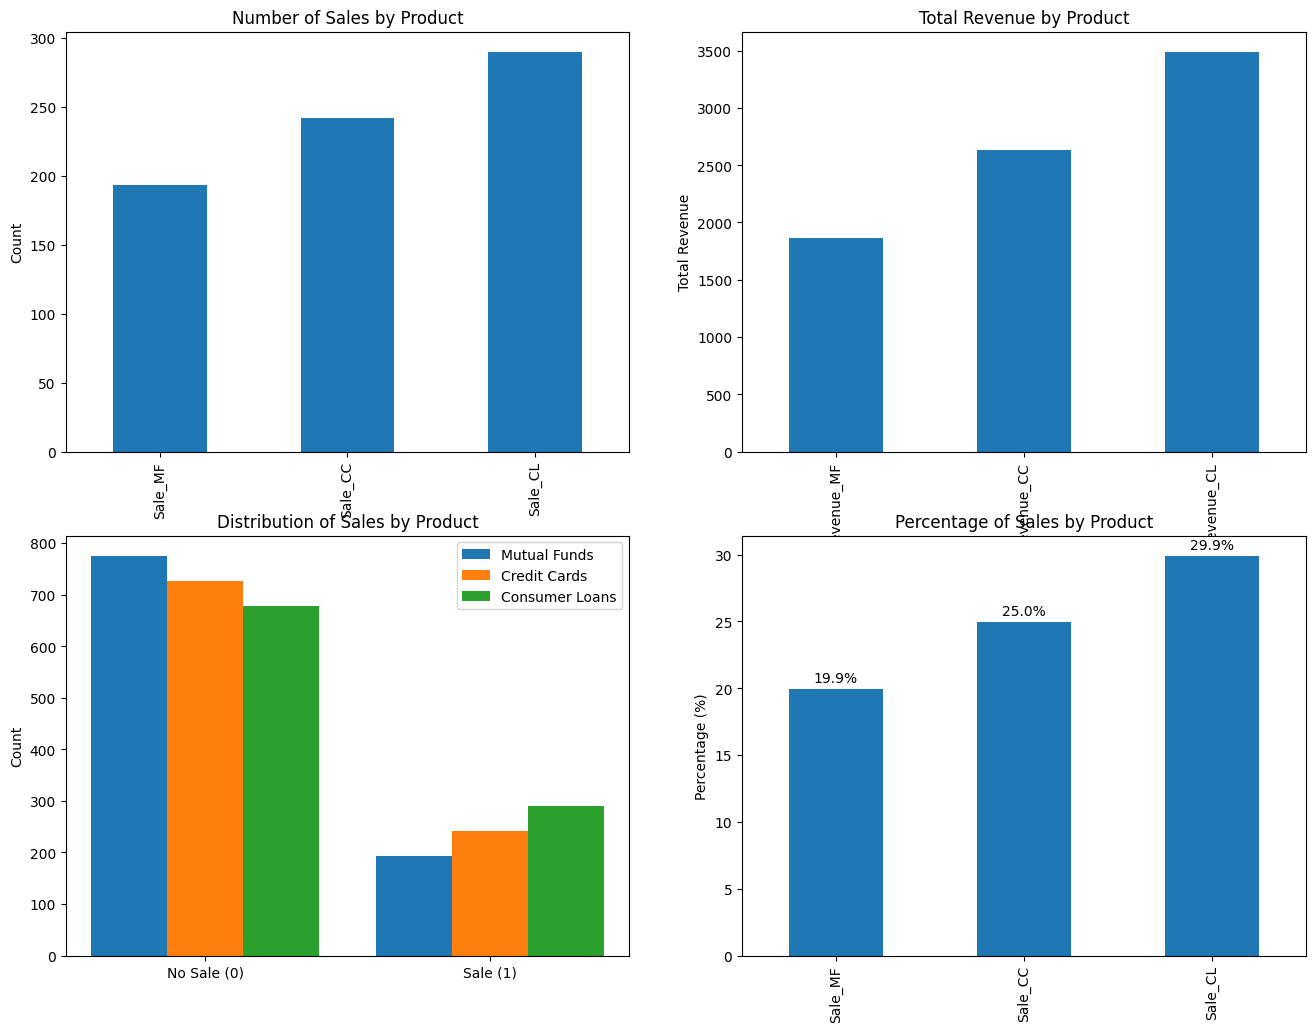

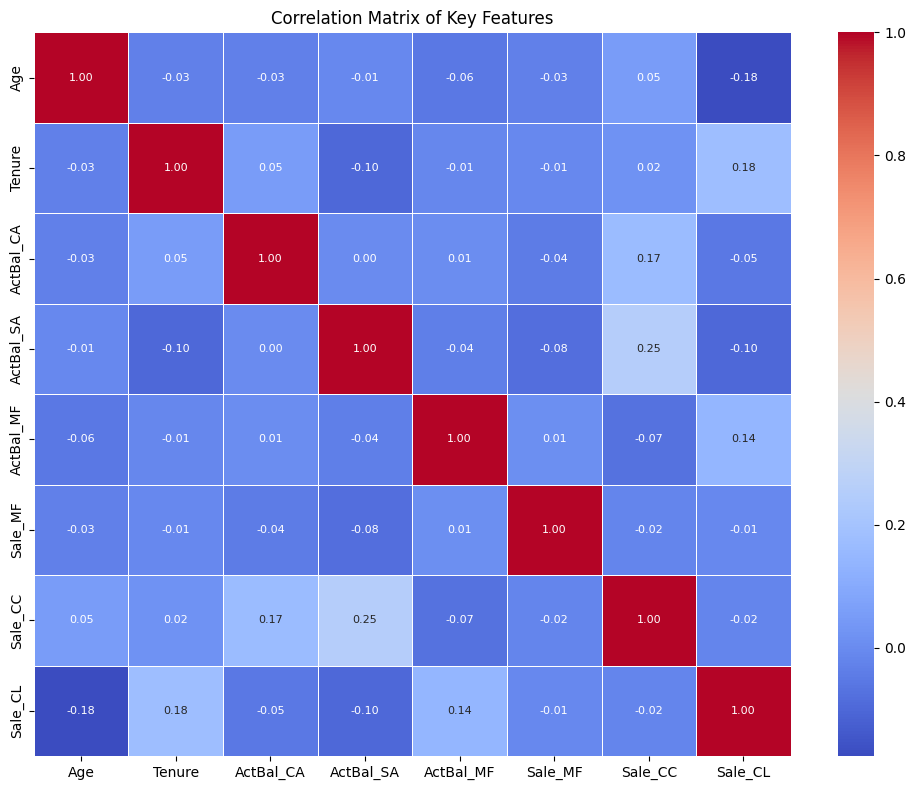


===== PART 2: MODEL TRAINING AND PREDICTION =====

Training model for MF products
Training set: 576 samples
Validation set: 193 samples
Test set: 200 samples
Positive samples in training: 102.0/576 (17.71%)
Starting cross-validation...
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation AUC: 0.5736
Training final model with best hyperparameters...
Final model metrics on validation set: {'accuracy': 0.772020725388601, 'auc': np.float64(0.5813543003851092), 'precision': 0.2857142857142857, 'recall': 0.04878048780487805, 'f1': 0.08333333333333333}
Generating predictions for test set...


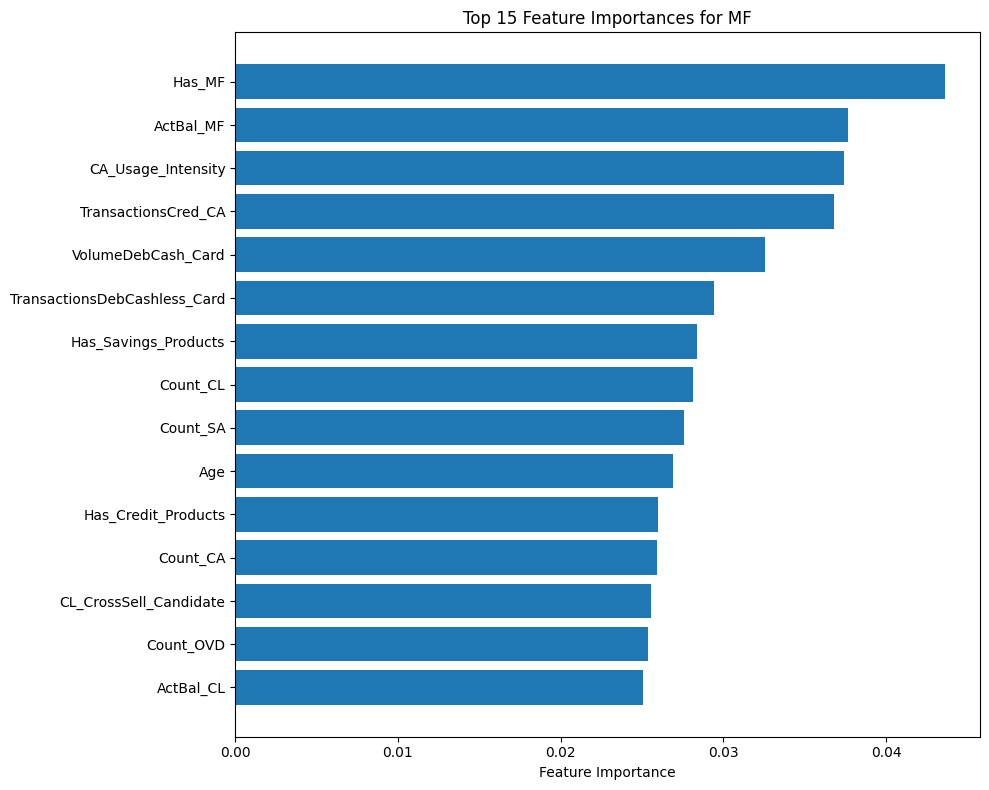


Training model for CC products
Training set: 576 samples
Validation set: 193 samples
Test set: 200 samples
Positive samples in training: 139.0/576 (24.13%)
Starting cross-validation...
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation AUC: 0.5764
Training final model with best hyperparameters...
Final model metrics on validation set: {'accuracy': 0.7823834196891192, 'auc': np.float64(0.48513800424628445), 'precision': 0.3125, 'recall': 0.1388888888888889, 'f1': 0.19230769230769232}
Generating predictions for test set...


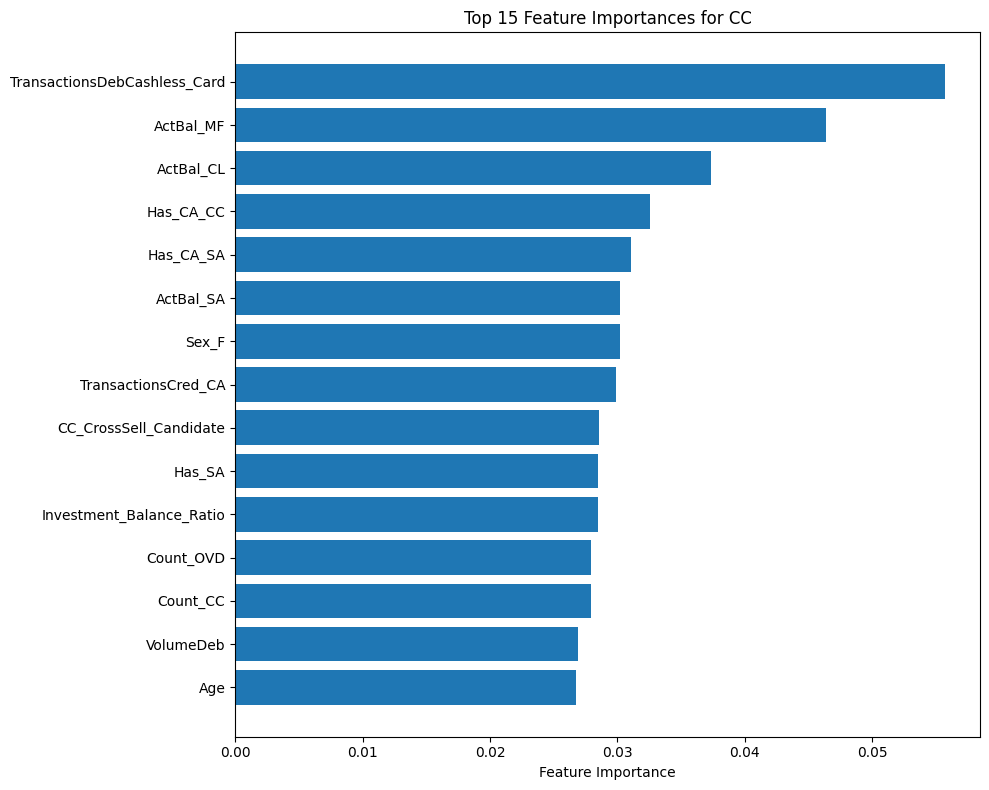


Training model for CL products
Training set: 576 samples
Validation set: 193 samples
Test set: 200 samples
Positive samples in training: 161.0/576 (27.95%)
Starting cross-validation...
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation AUC: 0.6718
Training final model with best hyperparameters...
Final model metrics on validation set: {'accuracy': 0.7564766839378239, 'auc': np.float64(0.6570541259982254), 'precision': 0.48148148148148145, 'recall': 0.2826086956521739, 'f1': 0.3561643835616438}
Generating predictions for test set...


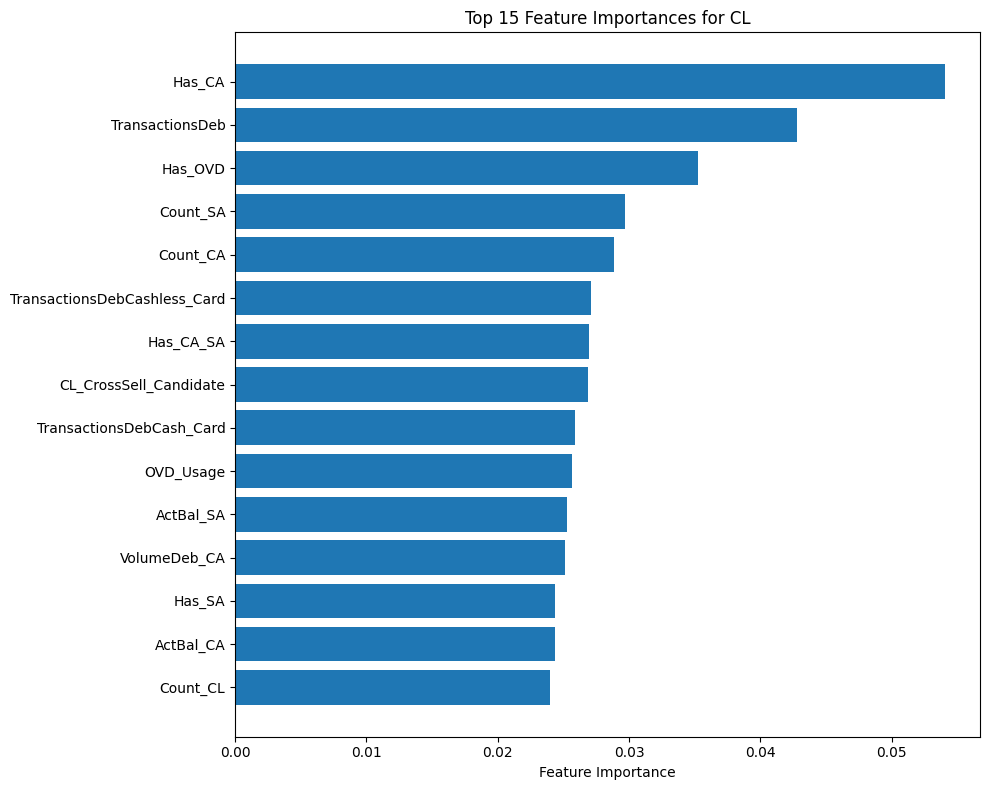


===== PART 3: REVENUE PREDICTION AND PROPENSITY SCORING =====

Average revenue by product per customer:
Revenue_MF    2.052146
Revenue_CC    2.268616
Revenue_CL    3.325466
dtype: float64

===== PART 4: CAMPAIGN OPTIMIZATION AND CLIENT TARGETING =====

===== PART 5: RESULTS ANALYSIS AND REPORTING =====

Marketing Campaign Optimization Results:
Number of targeted clients: 100
Total predicted revenue: 149.34
Total expected revenue: 724.77
Theoretical maximum revenue: 1833.47

Product Distribution in Final Selection:
CL: 57 clients
CC: 33 clients
MF: 10 clients

Targeted client list saved to 'targeted_clients.csv'

High Propensity Clients:

MF - Top 5 clients with highest propensity:
 Client  Propensity_MF  Revenue_MF
   1406       0.790263    0.000000
    230       0.740946    0.000000
    294       0.713284   10.098750
    790       0.669274    6.080179
     23       0.596296    0.000000

CC - Top 5 clients with highest propensity:
 Client  Propensity_CC  Revenue_CC
    478       0.978

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost.callback import EarlyStopping

# Load dataset
def load_data(file_path):
    xls = pd.ExcelFile(file_path)
    # Merge datasets on 'Client' column
    df = xls.parse('Soc_Dem').merge(
        xls.parse('Products_ActBalance'), on='Client', how='outer'
    ).merge(
        xls.parse('Inflow_Outflow'), on='Client', how='outer'
    ).merge(
        xls.parse('Sales_Revenues'), on='Client', how='outer'
    )
    target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL']
    return df.dropna(subset=target_cols).copy()

# Exploratory Data Analysis
def perform_eda(df):
    # Basic statistics
    print("Dataset shape:", df.shape)
    print("\nSummary statistics for key columns:")
    print(df[['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
             'Sale_MF', 'Sale_CC', 'Sale_CL']].describe())

    # Count of targets
    df['#Targets'] = df[['Sale_MF', 'Sale_CC', 'Sale_CL']].sum(axis=1)
    print("\nDistribution of number of targets per client:")
    print(df['#Targets'].value_counts())

    # Visualize sales and revenue distributions
    plt.figure(figsize=(16, 12))

    # Distribution of sales
    plt.subplot(2, 2, 1)
    sales_data = df[['Sale_MF', 'Sale_CC', 'Sale_CL']].sum()
    sales_data.plot(kind='bar', title='Number of Sales by Product')
    plt.ylabel('Count')

    # Distribution of revenue
    plt.subplot(2, 2, 2)
    rev_data = df[['Revenue_MF', 'Revenue_CC', 'Revenue_CL']].sum()
    rev_data.plot(kind='bar', title='Total Revenue by Product')
    plt.ylabel('Total Revenue')

    # Add distribution plots for sales variables
    plt.subplot(2, 2, 3)
    plt.title('Distribution of Sales by Product')
    plt.hist([
        df['Sale_MF'].values,
        df['Sale_CC'].values,
        df['Sale_CL'].values
    ], bins=[0, 0.5, 1], rwidth=0.8, align='mid', label=['Mutual Funds', 'Credit Cards', 'Consumer Loans'])
    plt.xticks([0.25, 0.75], ['No Sale (0)', 'Sale (1)'])
    plt.ylabel('Count')
    plt.legend()

    # Add percentage of sales for each product
    plt.subplot(2, 2, 4)
    sale_percentages = df[['Sale_MF', 'Sale_CC', 'Sale_CL']].mean() * 100
    sale_percentages.plot(kind='bar', title='Percentage of Sales by Product')
    plt.ylabel('Percentage (%)')
    for i, v in enumerate(sale_percentages):
        plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    corr_cols = ['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
                'Sale_MF', 'Sale_CC', 'Sale_CL']
    sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', annot_kws={"size": 8})
    plt.title('Correlation Matrix of Key Features')

    plt.tight_layout()
    plt.show()

    return df

def feature_engineering(df):
    """Comprehensive feature engineering for banking dataset"""
    features = df.copy()

    # 1. PRODUCT OWNERSHIP AND BALANCE FEATURES
    features['Has_CA'] = (features['Count_CA'] > 0).astype(int)
    features['Has_SA'] = (features['Count_SA'] > 0).astype(int)
    features['Has_MF'] = (features['Count_MF'] > 0).astype(int)
    features['Has_OVD'] = (features['Count_OVD'] > 0).astype(int)
    features['Has_CC'] = (features['Count_CC'] > 0).astype(int)
    features['Has_CL'] = (features['Count_CL'] > 0).astype(int)

    # Calculate total products and product diversity
    features['Total_Products'] = (features['Has_CA'] + features['Has_SA'] + features['Has_MF'] +
                                 features['Has_OVD'] + features['Has_CC'] + features['Has_CL'])

    # Product combinations
    features['Has_CA_SA'] = (features['Has_CA'] & features['Has_SA']).astype(int)
    features['Has_CA_CC'] = (features['Has_CA'] & features['Has_CC']).astype(int)
    features['Has_Savings_Products'] = (features['Has_SA'] | features['Has_MF']).astype(int)
    features['Has_Credit_Products'] = (features['Has_CC'] | features['Has_CL'] | features['Has_OVD']).astype(int)

    # Handle balances properly
    features['Total_Asset_Balance'] = features[['ActBal_CA', 'ActBal_SA', 'ActBal_MF']].sum(axis=1).clip(lower=0)
    features['Total_Liability'] = abs(features['ActBal_OVD']) + abs(features['ActBal_CC']) + abs(features['ActBal_CL'])
    features['Net_Balance'] = features['Total_Asset_Balance'] - features['Total_Liability']

    # Asset to liability ratio (with handling for zero liabilities)
    features['Asset_To_Liability_Ratio'] = np.where(
        features['Total_Liability'] > 0,
        features['Total_Asset_Balance'] / features['Total_Liability'],
        features['Total_Asset_Balance'] * 10
    )

    # 2. TRANSACTION BEHAVIOR FEATURES
    features['Monthly_Transaction_Count'] = features['TransactionsCred'] + features['TransactionsDeb']
    features['Avg_Transaction_Value'] = (features['VolumeCred'] + features['VolumeDeb']) / \
                                       features['Monthly_Transaction_Count'].replace(0, 1)

    features['Cash_Transaction_Ratio'] = features['TransactionsDebCash_Card'] / features['TransactionsDeb'].replace(0, 1)
    features['Cashless_Transaction_Ratio'] = features['TransactionsDebCashless_Card'] / features['TransactionsDeb'].replace(0, 1)
    features['Credit_To_Debit_Ratio'] = features['VolumeCred'] / features['VolumeDeb'].replace(0, 1)

    # 3. CLIENT RELATIONSHIP FEATURES
    features['Client_Tenure_Years'] = features['Tenure'] / 12
    features['Age_To_Tenure_Ratio'] = features['Age'] / (features['Tenure'] / 12).replace(0, 0.1)
    features['Product_Acquisition_Rate'] = features['Total_Products'] / (features['Tenure'] / 12).replace(0, 0.1)

    # 4. PRODUCT UTILIZATION AND CROSS-SELL POTENTIAL FEATURES
    features['CA_Usage_Intensity'] = ((features['TransactionsCred_CA'] + features['TransactionsDeb_CA']) /
                                     features['Count_CA'].replace(0, 1))
    features['OVD_Usage'] = (features['ActBal_OVD'].abs() > 0).astype(int)

    features['Investment_Balance_Ratio'] = np.where(
        features['Total_Asset_Balance'] > 0,
        features['ActBal_MF'] / features['Total_Asset_Balance'],
        0
    )

    # 5. CROSS-SELL INDICATORS
    features['MF_CrossSell_Candidate'] = ((features['Has_SA'] == 1) & (features['Has_MF'] == 0)).astype(int)
    features['CC_CrossSell_Candidate'] = ((features['Has_CA'] == 1) &
                                         (features['TransactionsDeb_CA'] > 5) &
                                         (features['Has_CC'] == 0)).astype(int)
    features['CL_CrossSell_Candidate'] = ((features['Total_Products'] >= 2) & (features['Has_CL'] == 0)).astype(int)

    return features

def preprocess_for_model(df, target_cols):
    """Preprocess banking dataset for classification model"""
    df_copy = df.copy()

    # Identify column types
    excl_cols = ['Client', '#Targets', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']
    categorical_cols = ["Sex"]
    binary_cols = ['Has_CA', 'Has_SA', 'Has_MF', 'Has_OVD', 'Has_CC', 'Has_CL',
                  'Has_CA_SA', 'Has_CA_CC', 'Has_Savings_Products', 'Has_Credit_Products',
                  'OVD_Usage', 'MF_CrossSell_Candidate', 'CC_CrossSell_Candidate', 'CL_CrossSell_Candidate']
    numeric_cols = [col for col in df_copy.columns if col not in excl_cols+target_cols+categorical_cols+binary_cols]

    # Create transformers for each column type
    numeric_transformer = 'passthrough'

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    binary_transformer = 'passthrough'

    # Combine all transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('bin', binary_transformer, binary_cols)
        ],
        remainder='drop'
    )

    # Fit and transform the data
    X_preprocessed = preprocessor.fit_transform(df_copy)

    # Get feature names after preprocessing
    feature_names = []
    if categorical_cols:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        for i, col in enumerate(categorical_cols):
            for cat in ohe.categories_[i]:
                feature_names.append(f"{col}_{cat}")
    feature_names.extend(binary_cols)
    feature_names.extend(numeric_cols)

    return X_preprocessed, preprocessor, feature_names

def evaluate_classification_model(model, X_test, y_test):
    """Evaluates a classification model using standard metrics."""
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def cross_validate_xgb_model(X, y, param_grid, n_splits=5, verbose=0):
    """Cross-validate XGBoost model with different hyperparameters"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create XGBoost classifier - remove use_label_encoder
    xgb = XGBClassifier(eval_metric='auc', random_state=42)

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=kf,
        verbose=verbose,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid_search.fit(X, y)

    # Get results
    cv_results = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }

    return cv_results, grid_search.best_estimator_


def train_product_model(df, df_test, product_code, verbose=1):
    """Train an XGBoost model for a specific product and generate predictions"""
    if verbose > 0:
        print(f"\n{'='*50}")
        print(f"Training model for {product_code} products")
        print(f"{'='*50}")

    # Define target column for this product
    target_col = f'Sale_{product_code}'

    # Remove the test set rows from the original dataframe
    df_train_val = df.drop(df_test.index)

    # Preprocess data
    X_train_val_preprocessed, preprocessor, feature_names = preprocess_for_model(
        df_train_val, target_cols=['Sale_MF', 'Sale_CC', 'Sale_CL'])
    y_train_val = df_train_val[target_col].values

    # Process test data
    X_test_preprocessed = preprocessor.transform(df_test)

    # Split training/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val_preprocessed, y_train_val, test_size=0.25, random_state=42)

    if verbose > 0:
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test_preprocessed.shape[0]} samples")
        print(f"Positive samples in training: {sum(y_train)}/{len(y_train)} ({sum(y_train)/len(y_train)*100:.2f}%)")

    # Define hyperparameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Cross-validate
    if verbose > 0:
        print("Starting cross-validation...")
    cv_results, best_model = cross_validate_xgb_model(
        X_train_val_preprocessed, y_train_val, param_grid, n_splits=5, verbose=verbose-1)

    if verbose > 0:
        print(f"Best hyperparameters: {cv_results['best_params']}")
        print(f"Best cross-validation AUC: {cv_results['best_score']:.4f}")

    # Train final model on all training data
    if verbose > 0:
        print("Training final model with best hyperparameters...")

    # Create final model with best parameters and set early_stopping_rounds in the model itself
    final_params = cv_results['best_params'].copy()
    # We'll use standard parameters but also include early_stopping
    final_model = XGBClassifier(
        **final_params,
        eval_metric='auc',
        random_state=42
    )

    # Set up evaluation set
    eval_set = [(X_val, y_val)]

    # Fit the model using eval_set
    # The early_stopping_rounds parameter is passed here
    final_model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )

    # Manually use early stopping with best_iteration if needed
    if hasattr(final_model, 'best_iteration'):
        print(f"Best iteration: {final_model.best_iteration}")

    # Evaluate on validation set
    val_metrics = evaluate_classification_model(final_model, X_val, y_val)
    if verbose > 0:
        print(f"Final model metrics on validation set: {val_metrics}")

    # Get predictions for test set
    if verbose > 0:
        print("Generating predictions for test set...")
    predictions = final_model.predict_proba(X_test_preprocessed)[:, 1]

    # Plot feature importance
    if verbose > 0:
        plt.figure(figsize=(10, 8))
        top_n = min(15, len(feature_names))  # Ensure top_n doesn't exceed feature length

        # Get feature importances
        importances = final_model.feature_importances_
        indices = np.argsort(importances)[-top_n:]

        # Plot
        plt.barh(range(len(indices)), importances[indices])
        # Make sure indices don't exceed feature_names length
        plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f'feature_{i}' for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Feature Importances for {product_code}')
        plt.tight_layout()
        plt.show()

    return predictions, final_model

def main():
    # PART 1: DATA LOADING AND PREPARATION
    # --------------------------------------
    print("\n===== PART 1: DATA LOADING AND PREPARATION =====")
    # Load and prepare data
    file_path = "DataScientist_CaseStudy_Dataset.xlsx"
    df = load_data(file_path)

    # Perform Exploratory Data Analysis
    df = perform_eda(df)

    # Apply feature engineering
    df = feature_engineering(df)

    # Create test set - 200 clients with exactly one product purchase
    df['#Targets'] = df[['Sale_MF', 'Sale_CC', 'Sale_CL']].sum(axis=1)
    df_test = df[df['#Targets'] == 1].sample(n=200, random_state=42)


    # PART 2: MODEL TRAINING AND PREDICTION
    # --------------------------------------
    print("\n===== PART 2: MODEL TRAINING AND PREDICTION =====")
    # Train models for each product and get predictions
    predictions_df = df_test.copy()
    product_codes = ['MF', 'CC', 'CL']
    models = {}

    for product_code in product_codes:
        predictions, model = train_product_model(df, df_test, product_code)
        predictions_df[f'Pred_Sale_{product_code}'] = predictions
        models[product_code] = model


    # PART 3: REVENUE PREDICTION AND PROPENSITY SCORING
    # ------------------------------------------------
    print("\n===== PART 3: REVENUE PREDICTION AND PROPENSITY SCORING =====")
    # Calculate average revenue for each product per customer
    df_train_val = df.drop(df_test.index)
    avg_revenue = df_train_val[['Revenue_MF', 'Revenue_CC', 'Revenue_CL']].mean()
    print("\nAverage revenue by product per customer:")
    print(avg_revenue)

    # Calculate predicted revenue based on average revenue per product
    predictions_df['Pred_Revenue_MF'] = predictions_df['Pred_Sale_MF'] * avg_revenue['Revenue_MF']
    predictions_df['Pred_Revenue_CC'] = predictions_df['Pred_Sale_CC'] * avg_revenue['Revenue_CC']
    predictions_df['Pred_Revenue_CL'] = predictions_df['Pred_Sale_CL'] * avg_revenue['Revenue_CL']

    # Calculate propensity scores and identify high-propensity clients
    for product_code in ['MF', 'CC', 'CL']:
        # Sort by sale prediction
        temp_df = predictions_df.sort_values(by=f'Pred_Sale_{product_code}', ascending=False)
        # Create propensity column
        predictions_df[f'Propensity_{product_code}'] = 0.0

        # Set propensity for top 100 clients
        top_clients = temp_df.iloc[:100]['Client'].values
        predictions_df.loc[predictions_df['Client'].isin(top_clients), f'Propensity_{product_code}'] = \
            predictions_df.loc[predictions_df['Client'].isin(top_clients), f'Pred_Sale_{product_code}']


    # PART 4: CAMPAIGN OPTIMIZATION AND CLIENT TARGETING
    # ------------------------------------------------
    print("\n===== PART 4: CAMPAIGN OPTIMIZATION AND CLIENT TARGETING =====")
    # Determine the best product to offer each client
    predictions_df['Max_Pred_Revenue'] = predictions_df[['Pred_Revenue_MF', 'Pred_Revenue_CC', 'Pred_Revenue_CL']].max(axis=1)
    predictions_df['Max_Pred_Revenue_Product'] = predictions_df[['Pred_Revenue_MF', 'Pred_Revenue_CC', 'Pred_Revenue_CL']].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

    # Calculate expected revenue from actual data
    predictions_df['Expected_Revenue'] = predictions_df.apply(
        lambda row: row[f"Revenue_{row['Max_Pred_Revenue_Product']}"], axis=1)

    # Select top 100 clients by predicted revenue for targeting
    targeted_clients = predictions_df.sort_values(by='Max_Pred_Revenue', ascending=False).iloc[:100]


    # PART 5: RESULTS ANALYSIS AND REPORTING
    # -------------------------------------
    print("\n===== PART 5: RESULTS ANALYSIS AND REPORTING =====")
    # Calculate campaign performance metrics
    print("\nMarketing Campaign Optimization Results:")
    print(f"Number of targeted clients: {len(targeted_clients)}")
    print(f"Total predicted revenue: {targeted_clients['Max_Pred_Revenue'].sum():.2f}")
    print(f"Total expected revenue: {targeted_clients['Expected_Revenue'].sum():.2f}")

    # Calculate max theoretical revenue
    predictions_df['Max_Revenue'] = predictions_df[['Revenue_MF','Revenue_CC','Revenue_CL']].max(axis=1)
    theoretical_max = predictions_df.sort_values(by='Max_Revenue', ascending=False).iloc[:100]['Max_Revenue'].sum()
    print(f"Theoretical maximum revenue: {theoretical_max:.2f}")

    # Count targeted clients by product
    product_counts = targeted_clients['Max_Pred_Revenue_Product'].value_counts()
    print("\nProduct Distribution in Final Selection:")
    for product, count in product_counts.items():
        print(f"{product}: {count} clients")

    # Save results to CSV file
    targeted_clients[['Client', 'Max_Pred_Revenue_Product', 'Max_Pred_Revenue', 'Expected_Revenue']].to_csv('targeted_clients.csv', index=False)
    print("\nTargeted client list saved to 'targeted_clients.csv'")

    # Display high propensity clients for each product
    print("\nHigh Propensity Clients:")
    for product in ['MF', 'CC', 'CL']:
        high_prop = predictions_df[predictions_df[f'Propensity_{product}'] > 0].sort_values(
            by=f'Propensity_{product}', ascending=False)
        print(f"\n{product} - Top 5 clients with highest propensity:")
        print(high_prop[['Client', f'Propensity_{product}', f'Revenue_{product}']].head().to_string(index=False))

    # Executive summary metrics
    print("\nExecutive Summary Metrics:")
    print(f"Total expected campaign revenue: {targeted_clients['Expected_Revenue'].sum():.2f}")
    print(f"Model efficiency: {(targeted_clients['Expected_Revenue'].sum() / theoretical_max) * 100:.2f}% of theoretical maximum")

if __name__ == "__main__":
    main()